Loaded 1081 rows


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Extracting CLIP embeddings: 100%|██████████| 1081/1081 [00:53<00:00, 20.07it/s]
/Users/roryashton/coding-repositories/ml-art-representation/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


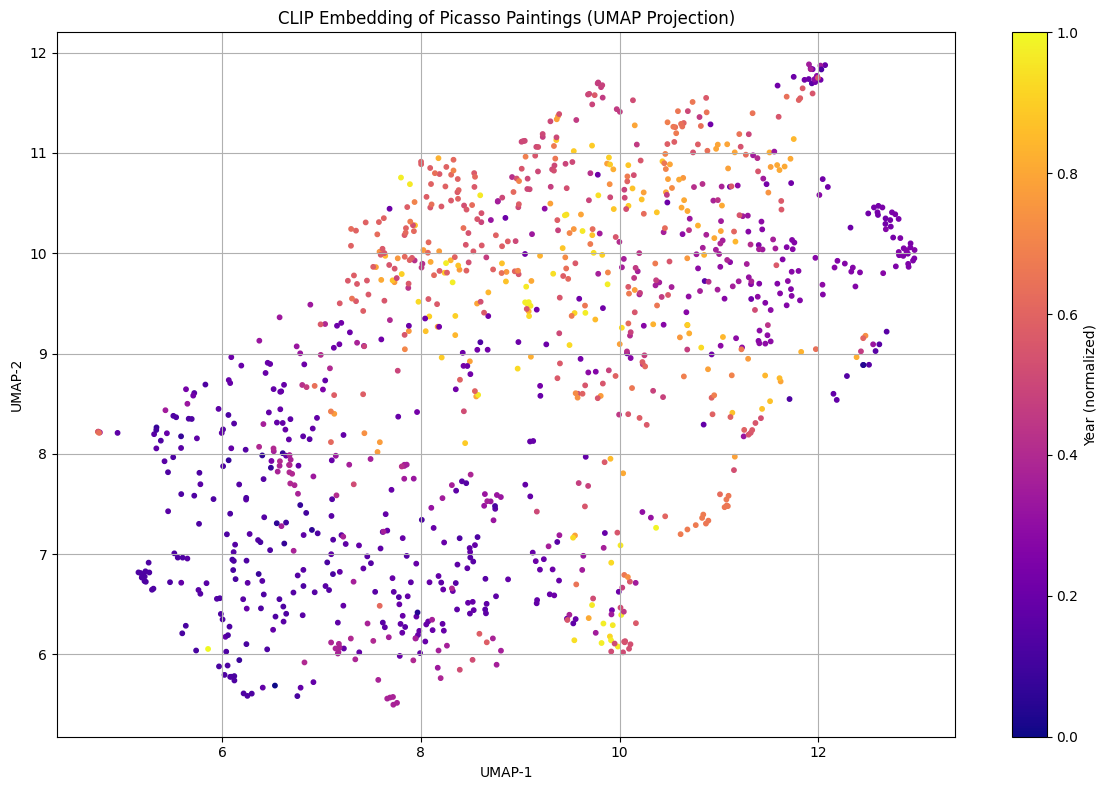

In [1]:
from pathlib import Path
import os
import pandas as pd
import torch
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import CLIPProcessor, CLIPModel

_HERE = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
_ROOT = _HERE.parent  # project root
DATA_DIR = _ROOT / "data" / "paintings"
CSV_PATH = _ROOT / "data" / "paintings.csv"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return clip_processor(images=image, return_tensors="pt")["pixel_values"]

embeddings = []
failed_files = []

for filename in tqdm(df["filename"], desc="Extracting CLIP embeddings"):
    try:
        image_path = DATA_DIR / filename
        pixel_values = preprocess_image(image_path).to(DEVICE)

        with torch.no_grad():
            embedding = clip_model.get_image_features(pixel_values=pixel_values)
            embedding = embedding.squeeze().cpu().numpy()
            embeddings.append(embedding)
    except Exception as e:
        failed_files.append((filename, str(e)))
        embeddings.append([0.0] * 512)  # Dummy vector if fail

df["embedding"] = embeddings

embedding_matrix = pd.DataFrame(embeddings)
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embedding_matrix)

df["x"] = embedding_2d[:, 0]
df["y"] = embedding_2d[:, 1]

scaler = MinMaxScaler()
df["year_norm"] = scaler.fit_transform(df[["year"]])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df["x"], df["y"], c=df["year_norm"], cmap="plasma", s=10)
cbar = plt.colorbar(scatter)
cbar.set_label("Year (normalized)")
plt.title("CLIP Embedding of Picasso Paintings (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()
